In [1]:
from os.path import exists 
import pandas as pd
import shap
from catboost import CatBoostClassifier
from sklearn.svm import SVC

from utils.data_preparation import *
from utils.data_exploration import *
from utils.training import *



task = "cyp1a2"

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [2]:
pd.read_csv(f"optimization/{task}/best.csv", comment="#").sort_values("val_mcc", ascending=False)

,model,val_accuracy,val_f1,val_mcc,false_negative_rate,false_positive_rate
3,CatBoost,0.87,0.87,0.74,0.11,0.15
0,SVC,0.87,0.87,0.73,0.12,0.14
5,XGBoost,0.86,0.86,0.73,0.11,0.17
2,LogisticRegression,0.86,0.85,0.71,0.14,0.15
1,RandomForest,0.84,0.83,0.68,0.20,0.12
4,KNN,0.81,0.80,0.61,0.20,0.19


# Data

In [3]:
# load thedataset
data = data_preprocessing(task)

# we only use Morgan fingerprints
data = data.drop(["MACCS_FP", "ATOMPAIR_FP"], axis=1)

# druglike molecules
data = select_druglike_molecules(data)

# turn string of fingerprints into single features
morgan_fingerprint_df = pd.DataFrame(
    convert_strings_to_int_array(data["Morgan_FP"].values), index=data.index
)
data = data.merge(morgan_fingerprint_df, left_index=True, right_index=True)

# remove NaN values
data_nan = extract_null(data)
data = data.drop(data_nan.index)

display(data)

# split data in train, val, test
datasets = dataset_split(data.drop(["Drug", "Drug_ID", "Morgan_FP"], axis=1))
# The descriptors include discrete and continuous data, distinguished by their dtype.
feature_groups = get_feature_groups(datasets, morgan_fingerprint_df)

Dataset already exists, returning data/cyp1a2/raw_dataset.csv.
Number of molecules before druglikeliness selection: 12579
Number of druglike molecules: 12138


,Y,Drug,Drug_ID,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1,6602638.0,11.609395,0.039701,11.609395,0.039701,0.906872,309.841,285.649,...,0,0,0,0,0,0,0,0,0,0
1,1,O=c1[nH]c2cc3c(cc2cc1CN(CCCO)Cc1nnnn1Cc1ccc(F)...,644510.0,13.221898,-0.305076,13.221898,0.022394,0.383547,466.473,443.289,...,0,0,0,0,0,0,0,0,0,0
2,1,CCN1C(=O)/C(=C2\SC(=S)N(CCCOC)C2=O)c2ccccc21,1960010.0,12.820479,-0.183140,12.820479,0.128619,0.457873,362.476,344.332,...,0,0,0,0,0,0,1,0,0,0
3,1,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,644675.0,12.610408,-3.973681,12.610408,0.072387,0.720977,355.418,346.346,...,0,0,0,0,0,0,0,0,0,0
4,1,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,644851.0,6.126257,0.660427,6.126257,0.660427,0.756902,255.708,245.628,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12574,0,C=CC1=C[C@@H](O)[C@@H]2O[C@@H]2C12OCCCO2,16758815.0,9.674588,-0.801690,9.674588,0.174259,0.635371,210.229,196.117,...,0,0,0,0,0,0,0,0,0,0
12575,0,O=C1[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@H]4C3...,16758816.0,13.390757,-1.019880,13.390757,0.162294,0.455270,397.427,374.243,...,0,0,0,0,0,0,0,0,0,0
12576,0,CCN1C(=O)[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@...,16758817.0,12.817440,-0.985371,12.817440,0.131139,0.406549,335.356,314.188,...,0,0,0,0,0,0,0,0,0,0
12577,0,C[C@H](c1ccccc1)N1C(=O)[C@@H]2[C@@H](CC[C@@H]3...,16758818.0,13.179767,-1.161112,13.179767,0.077392,0.772281,357.406,334.222,...,0,0,0,0,0,0,0,0,0,0


Splitting the data into 70.00% training, 10.00% validation, and 20.00% testing.
Unique Datatypes: {dtype('int64'), dtype('float64')}


# CatBoost

In [4]:
file_loc = f"optimization/{task}/catboost_0.csv"

# print comments
comments = ""
with open(file_loc, "r") as f:
    for line in f:
        if line[0] == "#":
            comments+=line

print(comments)

# print hyperparameter optimization results
pd.read_csv(file_loc, comment="#").drop("Unnamed: 0", axis=1).sort_values("val_mcc", ascending=False).head()

# fix_model_params={'verbose': 0}
# main_metric=mcc
# model_params=[Integer(low=4, high=12, prior='uniform', transform='identity'), Real(low=2.0, high=10.0, prior='uniform', transform='identity'), Real(low=1, high=6, prior='uniform', transform='identity')]
# preprocessing_params=None



,max_depth,l2_leaf_reg,scale_pos_weight,var_threshold_continuous,var_threshold_discrete,var_threshold_fingerprint,corr_threshold,val_accuracy,val_f1,val_precision,val_recall,val_mcc,val_roc_auc_score,val_average_precision_score
40,5,2.302131,1.411973,0.045288,0.046431,0.007661,0.842173,0.867769,0.867550,0.846527,0.889643,0.736604,0.939164,0.935871
12,7,2.511163,1.261228,0.047375,0.038814,0.006074,0.826390,0.866116,0.864094,0.854063,0.874363,0.732404,0.941335,0.939190
36,4,7.958573,1.130923,0.049196,0.036651,0.010059,0.894129,0.864463,0.861953,0.854758,0.869270,0.728954,0.936646,0.933671
18,5,3.731181,1.149559,0.010092,0.028681,0.001801,0.947275,0.863636,0.860994,0.854515,0.867572,0.727270,0.934587,0.930225
37,4,8.140448,1.145332,0.041226,0.029329,0.009157,0.841706,0.863636,0.860524,0.856902,0.864177,0.727166,0.937179,0.933447


In [8]:
model = CatBoostClassifier(
    max_depth = 5, 
    l2_leaf_reg=2.302131,
    scale_pos_weight=1.411973,
    verbose=0
)

data_prep = DataPreprocessing(
    feature_groups,
    var_threshold = {"continuous": 0.045288, "discrete": 0.046431, "fingerprint":0.007661},
    corr_threshold = 0.842173
)


data_prep.fit(datasets["train"].drop("Y", axis=1), datasets["train"]["Y"])
x_train_prep = data_prep.transform(datasets["train"].drop("Y", axis=1))
x_val_prep = data_prep.transform(datasets["val"].drop("Y", axis=1))
x_test_prep = data_prep.transform(datasets["test"].drop("Y", axis=1))

model.fit(x_train_prep, datasets["train"]["Y"])

Accuracy: 86.69%
F1-score: 86.77%
Matthews correlation coefficient: 0.7356786356374441%


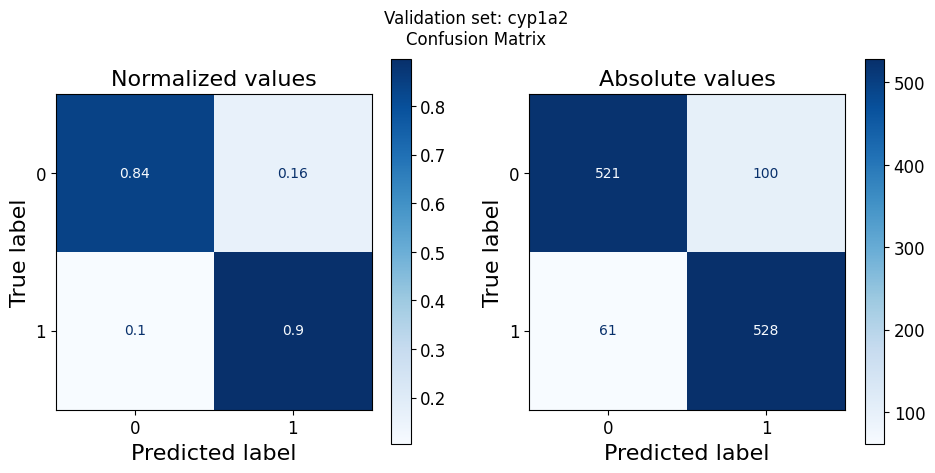

Accuracy: 84.72%
F1-score: 84.65%
Matthews correlation coefficient: 0.6972306649618953%


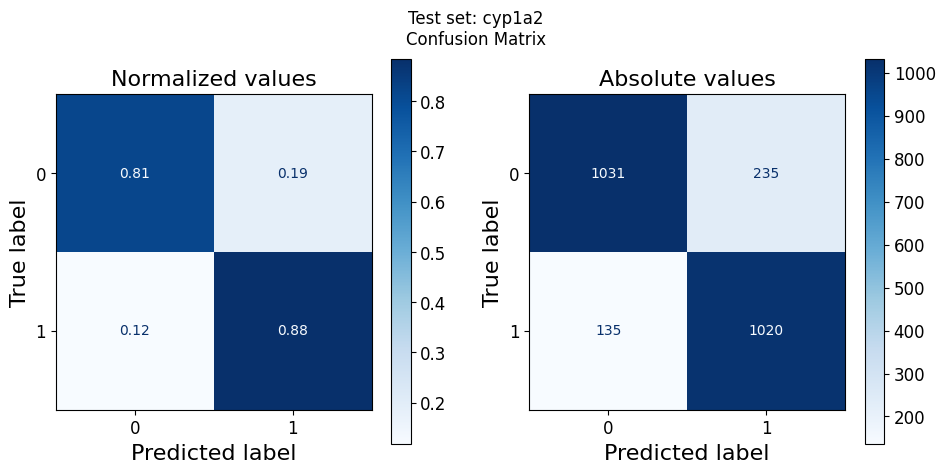

In [9]:
y_val_pred = model.predict(x_val_prep)
conf_matrix(datasets["val"]["Y"], y_val_pred, f"Validation set: {task}")

y_test_pred = model.predict(x_test_prep)
conf_matrix(datasets["test"]["Y"], y_test_pred, f"Test set: {task}")

## SHAP

In [10]:
# Add feature names to x_train_

data_norm = MinMaxScaler().fit_transform(datasets["train"].drop("Y", axis=1))
d1 = pd.DataFrame(data_norm, columns=datasets["train"].drop("Y", axis=1).columns)

d2 = pd.DataFrame(x_train_prep)
df = pd.concat([d2, d1], axis=1).T
x_train_prep_shap = df[df.duplicated()].T

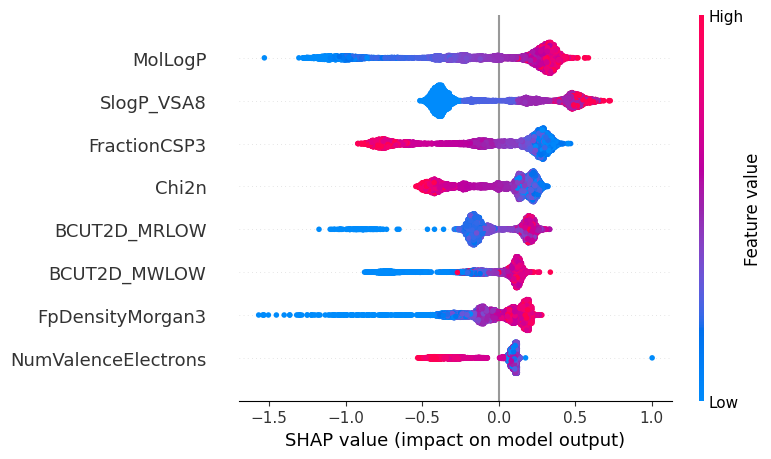

In [15]:
# load JS visualization code to notebook
shap.initjs()


model.fit(x_train_prep_shap, datasets["train"]["Y"])
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train_prep_shap)
shap.summary_plot(shap_values, x_train_prep_shap, max_display=8)